Loading model and tokenizer...
Model loaded successfully.
--- STARTING LAYER-SWEPT MEMORY ABLATION (N=1000 trials) ---


Sweeping Ablation Layer: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]




--- LAYER-SWEPT MEMORY ABLATION RESULTS ---
Baseline Accuracy (No Ablation): 100.00%
 Ablation Layer  Accuracy
              1       0.0
              2       0.0
              3       0.0
              4       0.0
              5       0.0
              6       0.0
              7       0.0
              8       1.0
              9       1.0
             10       1.0
             11       1.0
             12       1.0


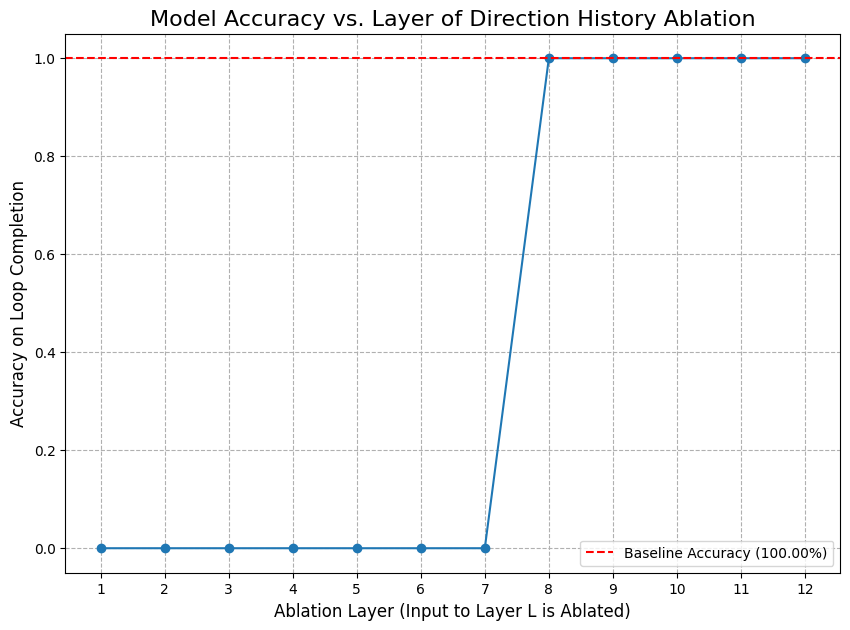

In [4]:
# Layer-Swept Memory Ablation Plot Recreation
# Tests when direction information becomes redundant in the model

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm.auto import tqdm

# Setup
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "/cs/student/projects1/aibh/2024/cbaumgar/model_chunked/checkpoint-73125"

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

class PositionalAblationPatcher:
    """Context manager to ablate (zero-out) hidden states at specific token positions."""
    def __init__(self, model, layer_idx, target_positions):
        self.model = model
        self.layer_idx = layer_idx
        self.target_positions = target_positions
        self.hook = None

    def _ablation_hook(self, module, module_input):
        original_hidden_states = module_input[0]
        patched_hidden_states = original_hidden_states.clone()
        for pos in self.target_positions:
            if pos < patched_hidden_states.shape[1]:
                patched_hidden_states[0, pos, :] = 0.0
        return (patched_hidden_states,) + module_input[1:]

    def __enter__(self):
        self.hook = self.model.transformer.h[self.layer_idx].register_forward_pre_hook(self._ablation_hook)

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.hook:
            self.hook.remove()

def run_layer_swept_memory_ablation(model, tokenizer, num_trials=100):
    """
    Ablates historical directions at each layer and measures the impact on accuracy.
    """
    print(f"--- STARTING LAYER-SWEPT MEMORY ABLATION (N={num_trials} trials) ---")
    
    # task generation
    tasks = []
    for _ in range(num_trials):
        templates = [
            "aa NORTH bb WEST cc SOUTH dd EAST",
            "ab EAST bb SOUTH cb WEST ca NORTH"
        ]
        prompt = random.choice(templates)
        expected_prediction = prompt.split()[0]
        tasks.append({'prompt': prompt, 'expected': expected_prediction})

    num_layers = model.config.n_layer
    results_by_layer = []

    # run ablation sweep
    for layer_to_ablate in tqdm(range(num_layers), desc="Sweeping Ablation Layer"):
        correct_predictions = 0
        display_idx = layer_to_ablate + 1  # shift index for reporting (1–12)

        for task in tasks:
            prompt = task['prompt']
            expected_token = task['expected']
            
            tokens = tokenizer(prompt, return_tensors="pt").to(DEVICE)
            decoded_tokens = [tokenizer.decode(t).strip() for t in tokens['input_ids'][0]]
            direction_vocab = {"NORTH", "SOUTH", "EAST", "WEST"}
            
            direction_positions_to_ablate = []
            for i, token_str in enumerate(decoded_tokens):
                if token_str in direction_vocab and i < (len(decoded_tokens) - 1):
                    direction_positions_to_ablate.append(i)
            
            with PositionalAblationPatcher(model, layer_to_ablate, direction_positions_to_ablate):
                with torch.no_grad():
                    ablated_outputs = model(**tokens)
            
            ablated_pred_id = torch.argmax(ablated_outputs.logits[0, -1, :]).item()
            ablated_pred_token = tokenizer.decode(ablated_pred_id).strip()
            
            if ablated_pred_token == expected_token:
                correct_predictions += 1
                
        accuracy = correct_predictions / num_trials
        results_by_layer.append({"Ablation Layer": display_idx, "Accuracy": accuracy})

    # baseline accuracy (no ablation)
    correct_baseline = 0
    for task in tasks:
        prompt = task['prompt']
        expected_token = task['expected']
        tokens = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            baseline_outputs = model(**tokens)
        baseline_pred_id = torch.argmax(baseline_outputs.logits[0, -1, :]).item()
        baseline_pred_token = tokenizer.decode(baseline_pred_id).strip()
        if baseline_pred_token == expected_token:
            correct_baseline += 1
    baseline_accuracy = correct_baseline / num_trials
    
    # plotting
    summary_df = pd.DataFrame(results_by_layer)
    
    print("\n\n" + "="*80)
    print("--- LAYER-SWEPT MEMORY ABLATION RESULTS ---")
    print("="*80)
    print(f"Baseline Accuracy (No Ablation): {baseline_accuracy:.2%}")
    print(summary_df.to_string(index=False))

    plt.figure(figsize=(10, 7))
    plt.plot(summary_df['Ablation Layer'], summary_df['Accuracy'], marker='o', linestyle='-')
    plt.axhline(baseline_accuracy, color='r', linestyle='--', label=f'Baseline Accuracy ({baseline_accuracy:.2%})')
    
    plt.title('Model Accuracy vs. Layer of Direction History Ablation', fontsize=16)
    plt.xlabel('Ablation Layer (Input to Layer L is Ablated)', fontsize=12)
    plt.ylabel('Accuracy on Loop Completion', fontsize=12)
    plt.xticks(range(1, num_layers + 1))
    plt.ylim(-0.05, 1.05)
    plt.grid(True, which='both', linestyle='--')
    plt.legend()
    plt.show()
    

# run experiment
if __name__ == "__main__":
    from transformers import GPT2LMHeadModel, GPT2TokenizerFast
    
    print("Loading model and tokenizer...")
    tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_PATH)
    model = GPT2LMHeadModel.from_pretrained(MODEL_PATH)
    model.to(DEVICE)
    model.eval()
    print("Model loaded successfully.")
    
    run_layer_swept_memory_ablation(model, tokenizer, num_trials=1000)